In [75]:
'''this is a bit of a silly experiment to see what VGG would do given map data
(VGG was probably the most successful image recognition neutal net circa 2017)
It seems to somewhat think the earth is a coral reef! or maybe a scuba diver! :D
this is not all silliness as we can use VGG for 'transfer learning', 
wherein we can either (a) train a new model starting from VGG or (b) use the first 
few layers of VGG to compue some more features which we can use in a classical classifer 
like gradient boost. '''

# please note I havent done a great job of commenting this yet. 

# more info at:
# https://keras.io/api/applications/vgg/#vgg16-function
# https://keras.io/guides/transfer_learning/#do-a-round-of-finetuning-of-the-entire-model
# https://ai-pool.com/d/keras-get-layer-of-the-model
# https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

Vmodel = VGG16(weights='imagenet', include_top=True)


In [76]:
Vmodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [78]:
input = Vmodel.get_layer('input_2')
layer1 = Vmodel.get_layer('block1_conv1')
layer2 = Vmodel.get_layer('block1_conv2')


In [79]:
import tensorflow.keras as keras

model = keras.Sequential([input, layer1, layer2])
layer1.trainable = False
layer2.trainable = False

In [80]:
!pip install git+https://github.com/NSCC-COGS/Aestheta.git

  Cloning https://github.com/NSCC-COGS/Aestheta.git to /tmp/pip-req-build-rww5yr1e
  Running command git clone -q https://github.com/NSCC-COGS/Aestheta.git /tmp/pip-req-build-rww5yr1e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for aestheta: filename=aestheta-1.0.0-cp37-none-any.whl size=3718344 sha256=dcc0edd74f8310e45198c050639ed0d670be58ac22bc0b746f8cd06cbde88938
  Stored in directory: /tmp/pip-ephem-wheel-cache-gjsk3035/wheels/c4/94/90/884591faef76c82b287cc1a743edf2e65da314fd82b9abaed8
Successfully built aestheta


In [81]:
from aestheta import core
a = core.getTile(source='google_sat')
# a = core.getTile(xyz=[2.3522,48.8566,10], source='google_sat')
# a = core.getTile(xyz=[-63.2,45.8566,10], source='google_sat')

0 0 0


In [82]:
print(a.shape)

(256, 256, 3)


In [83]:
import tensorflow as tf
a1=a[0:224,0:224,:]
a1 = a1.reshape((1, a1.shape[0], a1.shape[1], a1.shape[2]))
a2 = tf.keras.applications.vgg16.preprocess_input(a1)

In [84]:
b = Vmodel.predict(a2)

In [85]:
label = tf.keras.applications.vgg16.decode_predictions(b)

In [86]:
print(label)

[[('n09256479', 'coral_reef', 0.23004557), ('n10565667', 'scuba_diver', 0.13581733), ('n01498041', 'stingray', 0.09055573), ('n01494475', 'hammerhead', 0.059958145), ('n01491361', 'tiger_shark', 0.051434994)]]


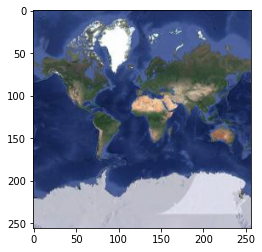

coral_reef 0.23004557
scuba_diver 0.13581733
stingray 0.09055573
hammerhead 0.059958145
tiger_shark 0.051434994


In [87]:
from matplotlib import pyplot as plt
plt.imshow(a)
plt.show()
for i in label[0]:
  print(i[1],i[2])

In [88]:
# https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer

from keras.models import Model
layer_name = 'block1_conv1'
model = Vmodel
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(a2)

In [89]:
# for i in range(intermediate_output.shape[3]):
#   plt.imshow(intermediate_output[0,:,:,i])
#   plt.show()

In [90]:
intermediate_output.shape

(1, 224, 224, 64)

In [91]:
big = intermediate_output[0]

In [92]:
big.shape

(224, 224, 64)

In [93]:
def img2features(img):
  features = img.reshape(-1, img.shape[2])
  return features

In [94]:
big_features = img2features(big)

In [95]:
big_features

array([[109.90278  ,  55.603123 ,   3.8766706, ...,  33.21099  ,
          0.       ,   4.9957232],
       [ 86.1757   ,  84.76716  ,   0.       , ...,  53.120426 ,
          0.       ,   0.       ],
       [ 87.34697  ,  84.6822   ,   0.       , ...,  54.09347  ,
          0.       ,   0.       ],
       ...,
       [247.73509  ,  47.961876 ,  73.853676 , ...,   0.       ,
          0.       ,  50.77069  ],
       [247.73509  ,  47.961876 ,  73.853676 , ...,   0.       ,
          0.       ,  50.77069  ],
       [401.01984  ,  31.550993 , 140.54483  , ...,   0.       ,
        111.43213  , 241.03563  ]], dtype=float32)

In [103]:
# https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_features = pca.fit_transform(big_features)

In [104]:
pca_features.shape

(50176, 3)

In [105]:
def features2img(features):
  img = features.reshape(224,224,3)
  return img

In [106]:
pca_image = features2img(pca_features)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


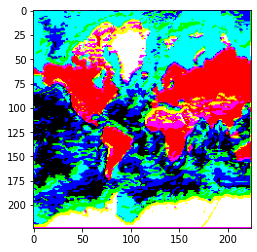

In [108]:
plt.imshow(pca_image[:,:,:])

In [109]:
pca_image.shape

(224, 224, 3)

In [110]:
map = core.getTile(source='google_map')

0 0 0


In [111]:
intermediate_output.shape

(1, 224, 224, 64)

In [112]:
avgg = intermediate_output[0,:,:,:]

In [113]:
map.shape

(256, 256, 4)

In [114]:
mvgg = map[0:224,0:224,:]

In [115]:
amod = core.simpleClassifier(avgg, mvgg)

training  classifier...
      Iter       Train Loss   Remaining Time 
         1         546.0971           12.59s
         2         480.3725           12.03s
         3         424.1531           11.58s
         4         383.7192           11.24s
         5         345.7241           11.07s
         6         318.4365           10.78s
         7         296.6377           10.60s
         8         275.5124           10.58s
         9         260.7467           10.43s
        10         248.3389           10.47s
        20         165.9284            8.80s
        30         126.6106            7.40s
        40         102.5650            6.16s
        50          84.0489            4.98s
        60          70.5731            3.93s
        70          59.9852            2.90s
        80          51.0766            1.91s
        90          43.8253            0.94s
       100          37.5772            0.00s


In [178]:
ns = [45.5,-63.5,19]
ns = [44.6488, -63.5752,6]
ns = [44.247682, -66.355587,10]
zoom = core.getTile(ns, 'google_sat')
zoom = zoom[0:224,0:224,:]

323 371 10


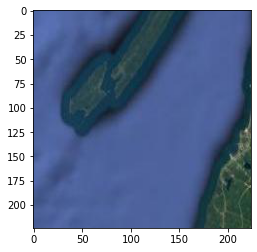

In [179]:
plt.imshow(zoom)

In [180]:
z=zoom[0:224,0:224,:]
z = z.reshape((1, z.shape[0], z.shape[1], z.shape[2]))
z = tf.keras.applications.vgg16.preprocess_input(z)
z = intermediate_layer_model.predict(z)[0]

In [181]:
z.shape

(224, 224, 64)

In [182]:
outz = core.classifyImage(z,*amod)

applying classification...


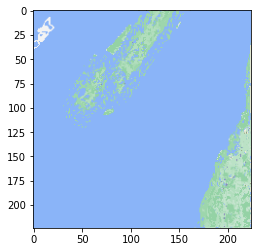

In [183]:
plt.imshow(outz)

In [155]:
outvgg = core.classifyImage(avgg,*amod)

applying classification...


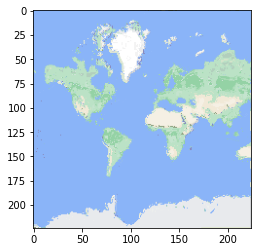

In [156]:
plt.imshow(outvgg)
plt.show()